# Synthea self-harm classification project: Model prep and testing

## Splitting and Preprocessing the data

In [67]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

file_path = '/Users/SarahA/synthea/final_data_modified.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

y = df['SuicideRelatedEvent']
columns_to_drop = ['PATIENT', 'Id', 'Id_x', 'Id_y', 'BIRTHDATE', 'DIAGNOSIS1', 'DIAGNOSIS2', 'DIAGNOSIS3', 'DIAGNOSIS4', 'DIAGNOSIS5', 'DIAGNOSIS6', 'DIAGNOSIS7', 'DIAGNOSIS8']
X = df.drop(columns=columns_to_drop)
groups = df['PATIENT']
classes, counts = np.unique(y,return_counts=True)
print(classes, counts)
print('balance:',np.max(counts/len(y)))

print(f'feature matrix size: {X.shape}')
# the feature names
ftrs = df.columns

[0 1] [9628  372]
balance: 0.9628
feature matrix size: (10000, 12)


In [54]:
print (df.columns)

# Display data types of variables
print(df.dtypes)

Index(['Id_x', 'PATIENT', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION', 'ENCOUNTERCLASS', 'Id_y', 'BIRTHDATE', 'RACE',
       'ETHNICITY', 'GENDER', 'INCOME', 'Id', 'DIAGNOSIS1', 'DIAGNOSIS2',
       'DIAGNOSIS3', 'DIAGNOSIS4', 'DIAGNOSIS5', 'DIAGNOSIS6', 'DIAGNOSIS7',
       'DIAGNOSIS8', 'SuicideRelatedEvent', 'INCOME_RANGE', 'Age'],
      dtype='object')
Id_x                    object
PATIENT                 object
CODE                     int64
DESCRIPTION             object
REASONCODE             float64
REASONDESCRIPTION       object
ENCOUNTERCLASS          object
Id_y                    object
BIRTHDATE               object
RACE                    object
ETHNICITY               object
GENDER                  object
INCOME                   int64
Id                      object
DIAGNOSIS1               int64
DIAGNOSIS2             float64
DIAGNOSIS3             float64
DIAGNOSIS4             float64
DIAGNOSIS5             float64
DIAGNOSIS6             float64
D

In [68]:
from sklearn.model_selection import GroupShuffleSplit

# Assuming X, y, and groups are your features, target variable, and group identifiers
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]

# Further split the training set into training and validation sets
gss_train = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, cv_index in gss_train.split(X_train, y_train, groups_train):
    X_train, X_val = X_train.iloc[train_index], X_train.iloc[cv_index]
    y_train, y_val = y_train.iloc[train_index], y_train.iloc[cv_index]
    groups_train, groups_val = groups_train.iloc[train_index], groups_train.iloc[cv_index]

# Print the sizes of the sets
print(f'Train size: {X_train.shape}')
print(f'Validation size: {X_val.shape}')
print(f'Test size: {X_test.shape}')

# Ensure class 1 cases are included in each set
print(f'Class 1 distribution in Train: {y_train.sum() / len(y_train):.4f}')
print(f'Class 1 distribution in Validation: {y_val.sum() / len(y_val):.4f}')
print(f'Class 1 distribution in Test: {y_test.sum() / len(y_test):.4f}')


Train size: (6004, 12)
Validation size: (1994, 12)
Test size: (2002, 12)
Class 1 distribution in Train: 0.0390
Class 1 distribution in Validation: 0.0306
Class 1 distribution in Test: 0.0385


In [69]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Calculate the majority class
majority_class = y_test.value_counts().idxmax()

# Calculate the baseline accuracy for the test set
baseline_test_accuracy = y_test.value_counts(normalize=True).max()
print(f'Test Baseline Accuracy: {baseline_test_accuracy:.4f}')

# Calculate y_pred_baseline (predicting the majority class for all instances)
y_pred_baseline = pd.Series([majority_class] * len(y_test), index=y_test.index)

# Calculate precision, recall, and AUC-ROC score for the baseline model for class 1
baseline_precision = precision_score(y_test, y_pred_baseline, pos_label=1, zero_division=1)
baseline_recall = recall_score(y_test, y_pred_baseline, pos_label=1)
baseline_auc_roc = roc_auc_score(y_test, y_pred_baseline)

# Print the results
print(f'Baseline Precision (Class 1): {baseline_precision:.4f}')
print(f'Baseline Recall (Class 1): {baseline_recall:.4f}')
print(f'Baseline AUC-ROC Score: {baseline_auc_roc:.4f}')

# Calculate the baseline F1 score for class 1
baseline_test_f1 = f1_score(y_test, y_pred_baseline, pos_label=1, average='binary')
print(f'Test Baseline F1 Score (Class 1): {baseline_test_f1:.4f}')


Test Baseline Accuracy: 0.9615
Baseline Precision (Class 1): 1.0000
Baseline Recall (Class 1): 0.0000
Baseline AUC-ROC Score: 0.5000
Test Baseline F1 Score (Class 1): 0.0000


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

num_ftrs = ['Age', 'INCOME', 'CODE', 'REASONCODE']
cat_ftrs = ['RACE', 'ETHNICITY', 'GENDER', 'DESCRIPTION', 'ENCOUNTERCLASS', 'REASONDESCRIPTION']
ordinal_ftrs = ['INCOME_RANGE']
ordinal_cats = [['0-25k', '25k-50k', '50k-75k', '75k-100k', '100k-150k', '150k+']]

# Create transformers for each type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories=ordinal_cats))])

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)],
    )

# Load and preprocess your data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the feature names for each transformer
numeric_feature_names = num_ftrs
categorical_feature_names = cat_ftrs
ordinal_feature_names = ordinal_ftrs

# Combine all feature names into a single list
feature_names = numeric_feature_names + list(categorical_feature_names) + ordinal_feature_names
print(feature_names)


['Age', 'INCOME', 'CODE', 'REASONCODE', 'RACE', 'ETHNICITY', 'GENDER', 'DESCRIPTION', 'ENCOUNTERCLASS', 'REASONDESCRIPTION', 'INCOME_RANGE']


In [71]:

preprocessor.fit(X_train)  

# Get feature names after preprocessing for each transformer
numeric_feature_names = preprocessor.named_transformers_['num'][-1].get_feature_names_out(num_ftrs)
categorical_feature_names = preprocessor.named_transformers_['cat'][-1].get_feature_names_out(cat_ftrs)
ordinal_feature_names = preprocessor.named_transformers_['ord'][-1].get_feature_names_out(ordinal_ftrs)

# Combine all feature names into a single list
feature_names = list(numeric_feature_names) + list(categorical_feature_names) + list(ordinal_feature_names)

print("Feature Names After Preprocessing:", feature_names)


Feature Names After Preprocessing: ['Age', 'INCOME', 'CODE', 'REASONCODE', 'RACE_asian', 'RACE_black', 'RACE_hawaiian', 'RACE_native', 'RACE_other', 'RACE_white', 'ETHNICITY_hispanic', 'ETHNICITY_nonhispanic', 'GENDER_F', 'GENDER_M', 'DESCRIPTION_Administration of vaccine to produce active immunity (procedure)', 'DESCRIPTION_Death Certification', 'DESCRIPTION_Emergency room admission (procedure)', 'DESCRIPTION_Encounter for problem', 'DESCRIPTION_General examination of patient (procedure)', 'DESCRIPTION_Well child visit (procedure)', 'ENCOUNTERCLASS_ambulatory', 'ENCOUNTERCLASS_emergency', 'ENCOUNTERCLASS_outpatient', 'ENCOUNTERCLASS_wellness', 'REASONDESCRIPTION_Attempted suicide - cut/stab', 'REASONDESCRIPTION_Attempted suicide - suffocation', 'REASONDESCRIPTION_Suicidal deliberate poisoning', 'REASONDESCRIPTION_Suicide - suffocation', 'REASONDESCRIPTION_missing', 'INCOME_RANGE']


### Missing data (post-processing)

In [68]:
# Calculate the percentage of missing values in each feature
perc_missing_per_ftr = X_train.isnull().sum(axis=0) / X_train.shape[0]

# Print the fraction of missing values in features
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Print the data types of the features with missing values
print('Data types of the features with missing values:')
print(X_train[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

# Calculate the fraction of points with missing values
frac_missing = sum(X_train.isnull().sum(axis=1) != 0) / X_train.shape[0]
print('Fraction of points with missing values:', frac_missing)

Fraction of missing values in features:
REASONCODE           0.961026
REASONDESCRIPTION    0.961026
dtype: float64
Data types of the features with missing values:
REASONCODE           float64
REASONDESCRIPTION     object
dtype: object
Fraction of points with missing values: 0.9610259826782145


## Random Forest Classifier

In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

# Define the classifier and the pipeline
classifier_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier_rf', classifier_rf)])

# Define the hyperparameter grid
param_grid = {
    'classifier_rf__n_estimators': [50, 100, 150],
    'classifier_rf__max_depth': [None, 10, 20, 30],
    'classifier_rf__min_samples_split': [2, 5, 10],
    'classifier_rf__min_samples_leaf': [1, 2, 4]
}

# Create a 10-fold stratified cross-validation object
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

# Display the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

# Save the best model
best_model = grid_search.best_estimator_

# Evaluate the model using 10-fold cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

# Display the cross-validated ROC-AUC scores
print("Cross-validated ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC Score:", cv_scores.mean())

# Fit the pipeline on the training data
best_model.fit(X, y)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train[['ENCOUNTERCLASS']])

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Save the validation and test scores to a list
model_scores = {
    'Best_Model': best_model,
    'Validation_ROC_AUC': cv_scores.mean(),
    'Test_Accuracy': accuracy,
    'Test_Precision': precision,
    'Test_Recall': recall,
    'Test_F1': f1,
    'Test_ROC_AUC': auc_roc
}

# Print and access the saved scores
for key, value in model_scores.items():
    print(f'{key}: {value}')

Best Hyperparameters: {'classifier_rf__max_depth': None, 'classifier_rf__min_samples_leaf': 1, 'classifier_rf__min_samples_split': 2, 'classifier_rf__n_estimators': 50}
Best ROC-AUC Score: 1.0
Cross-validated ROC-AUC Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean ROC-AUC Score: 1.0
Best_Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'INCOME', 'CODE',
                                                   'REASONCODE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
           

/Users/SarahA/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Examine feature importance (Random Forest)

Feature Importances:
Age: 0.016539470152261454
INCOME: 0.0004498493439748483
CODE: 0.040002343300461866
REASONCODE: 0.09954297523770556
RACE_asian: 1.715962186348285e-05
RACE_black: 1.444938116579731e-15
RACE_hawaiian: 3.384447498043495e-08
RACE_native: 1.082437215416163e-15
RACE_other: 2.4026047863012024e-15
RACE_white: 1.6232127869685626e-15
ETHNICITY_hispanic: 4.09389609211594e-07
ETHNICITY_nonhispanic: 1.5528241110988715e-15
GENDER_F: 0.0006177561930439952
GENDER_M: 0.0020137638129650655
DESCRIPTION_Administration of vaccine to produce active immunity (procedure): 0.014103843817770337
DESCRIPTION_Death Certification: 0.003057547251289906
DESCRIPTION_Emergency room admission (procedure): 0.02591177230562682
DESCRIPTION_Encounter for problem: 0.09528549538321117
DESCRIPTION_General examination of patient (procedure): 0.043606647845360835
DESCRIPTION_Well child visit (procedure): 0.011385158169601185
ENCOUNTERCLASS_ambulatory: 0.0628808859804207
ENCOUNTERCLASS_emergency: 0.02294960343

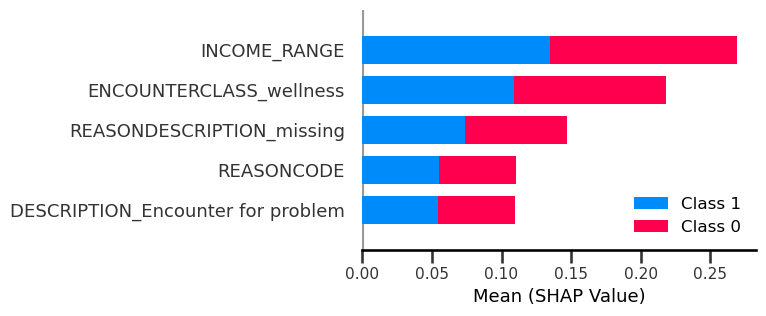

In [93]:
import shap
# Assuming best_model is your trained RandomForestClassifier
feature_importances = best_model.named_steps['classifier_rf'].feature_importances_

# Assuming feature_names is a list of your feature names
print("Feature Importances:")
for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance}")

# Assuming best_model is your trained RandomForestClassifier
explainer = shap.TreeExplainer(best_model.named_steps['classifier_rf'])

# Transform the test set
X_test_transformed = preprocessor.transform(X_test)

# Calculate SHAP values on the first 1000 points in the test set
shap_values = explainer.shap_values(X_test_transformed[:1000])

# Plot the summary plot for the top 5 features
shap.summary_plot(shap_values, X_test_transformed[:1000], feature_names=feature_names, plot_type="bar", max_display=5, show=False)

# Customize the y-axis label
plt.xlabel("Mean (SHAP Value)")

# Show the modified plot
plt.show()

In [78]:
# Assuming feature_names and feature_importances are already defined
# (based on the previous code snippets)

# Convert feature_names and top_features['Feature'] to sets
#set_feature_names = set(feature_names)
#set_top_features = set(top_features['Feature'])

# Identify the missing feature
#missing_feature = set_feature_names - set_top_features

#print("Missing Feature:", missing_feature)

#print("Length of feature_names:", len(feature_names))
#print("Length of feature_importances:", len(feature_importances))

***Plot the mean and standard deviation for the test scores (Random Forest)***

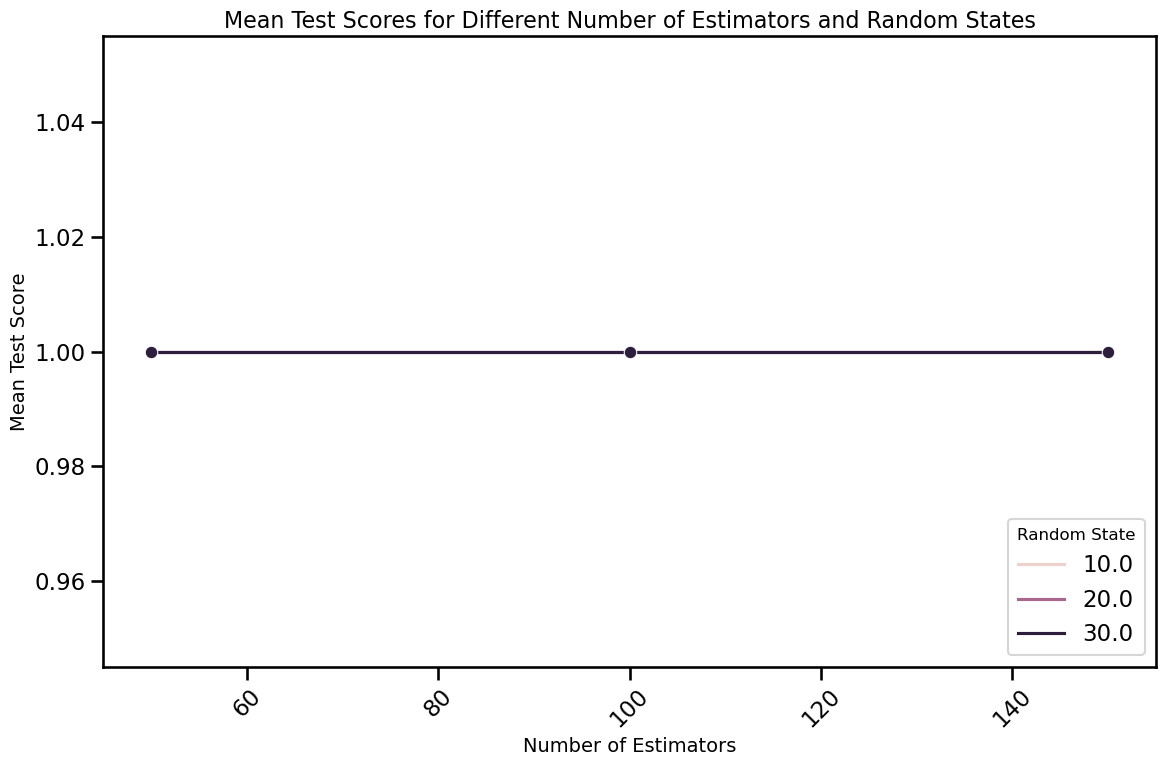

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract grid search results
grid_results = pd.DataFrame(grid_search.cv_results_)

# Set a larger font size
sns.set_context("talk")

# Define the hyperparameter to plot
param_to_plot = 'param_classifier_rf__n_estimators'  

# Extract random states from 'params' column
grid_results['random_state'] = grid_results['params'].apply(lambda x: x['classifier_rf__max_depth'])  

# Plot the mean test scores for each random state
plt.figure(figsize=(12, 8))
sns.lineplot(x=grid_results[param_to_plot], y=grid_results['mean_test_score'], hue=grid_results['random_state'], marker='o')

plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean Test Score', fontsize=14)
plt.title('Mean Test Scores for Different Number of Estimators and Random States', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Random State', title_fontsize='12', loc='lower right')
plt.tight_layout()
plt.show()

## Logistic Regression

In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

# Define the classifier and the pipeline for Logistic Regression
classifier_lr = LogisticRegression(class_weight='balanced', random_state=42)

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier_lr', classifier_lr)])

# Define the hyperparameter grid for Logistic Regression without 'l1' penalty
param_grid_lr = {
    'classifier_lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier_lr__penalty': ['l2']
}

# Create a 10-fold stratified cross-validation object
cv_lr = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform grid search with cross-validation for Logistic Regression
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv_lr, scoring='roc_auc', n_jobs=-1)
grid_search_lr.fit(X, y)

# Display the best hyperparameters and corresponding score for Logistic Regression
print("Best Hyperparameters:", grid_search_lr.best_params_)
print("Best ROC-AUC Score:", grid_search_lr.best_score_)

# Save the best Logistic Regression model
best_model_lr = grid_search_lr.best_estimator_

# Evaluate the model using 10-fold cross-validation
cv_scores_lr = cross_val_score(best_model_lr, X, y, cv=cv_lr, scoring='roc_auc', n_jobs=-1)

# Display the cross-validated ROC-AUC scores for Logistic Regression
print("Cross-validated ROC-AUC Scores:", cv_scores_lr)
print("Mean ROC-AUC Score:", cv_scores_lr.mean())

# Fit the pipeline on the training data
best_model_lr.fit(X, y)

# Make predictions on the test set
y_pred_lr = best_model_lr.predict(X_test)

# Evaluate the Logistic Regression model performance
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_roc_lr = roc_auc_score(y_test, best_model_lr.predict_proba(X_test)[:, 1])

# Save the validation and test scores for Logistic Regression to a list
model_scores_lr = {
    'Best_Model_LR': best_model_lr,
    'Validation_ROC_AUC_LR': cv_scores_lr.mean(),
    'Test_Accuracy_LR': accuracy_lr,
    'Test_Precision_LR': precision_lr,
    'Test_Recall_LR': recall_lr,
    'Test_F1_LR': f1_lr,
    'Test_ROC_AUC_LR': auc_roc_lr
}

# Print and access the saved scores for Logistic Regression
for key, value in model_scores_lr.items():
    print(f'{key}: {value}')

Best Hyperparameters: {'classifier_lr__C': 0.01, 'classifier_lr__penalty': 'l2'}
Best ROC-AUC Score: 1.0
Cross-validated ROC-AUC Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean ROC-AUC Score: 1.0
Best_Model_LR: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'INCOME', 'CODE',
                                                   'REASONCODE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='mis

***Examine feature importance (Logistic Regression)***

In [91]:
import shap

# Assuming best_model_lr is your trained Logistic Regression model
logistic_regression_model = best_model_lr.named_steps['classifier_lr']

# Get the coefficients from the logistic regression model
coefficients = logistic_regression_model.coef_[0]

# Combine feature names and coefficients into a list of tuples
feature_coefficients = list(zip(feature_names, coefficients))

# Sort the list by the absolute values of coefficients in descending order
feature_coefficients_sorted = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Print the feature names and coefficients in descending order of importance
print("Feature Coefficients (Descending Order):")
for feature, coefficient in feature_coefficients_sorted:
    print(f"{feature}: {coefficient}")


Feature Coefficients (Descending Order):
INCOME_RANGE: -1.8732255690333166
REASONDESCRIPTION_Suicidal deliberate poisoning: 1.1327532711584087
ENCOUNTERCLASS_wellness: -1.0944782605145034
DESCRIPTION_Encounter for problem: 1.0627233020349516
ENCOUNTERCLASS_ambulatory: 1.0627233020349516
DESCRIPTION_General examination of patient (procedure): -0.8850913112301018
DESCRIPTION_Emergency room admission (procedure): 0.6263136221387533
ENCOUNTERCLASS_emergency: 0.6263136221387533
DESCRIPTION_Administration of vaccine to produce active immunity (procedure): -0.594554507378368
ENCOUNTERCLASS_outpatient: -0.594554507378368
DESCRIPTION_Well child visit (procedure): -0.39357975042484694
Age: 0.38645880706485775
REASONDESCRIPTION_Attempted suicide - cut/stab: 0.2971381649614774
CODE: -0.2841000921592868
REASONDESCRIPTION_Attempted suicide - suffocation: 0.25914548805381904
GENDER_F: 0.20649054088663987
GENDER_M: -0.20648638460580632
DESCRIPTION_Death Certification: 0.18419280114044517
REASONDESCRIP

***Plot the mean and standard deviation for the test scores (Logistic Regression)***

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

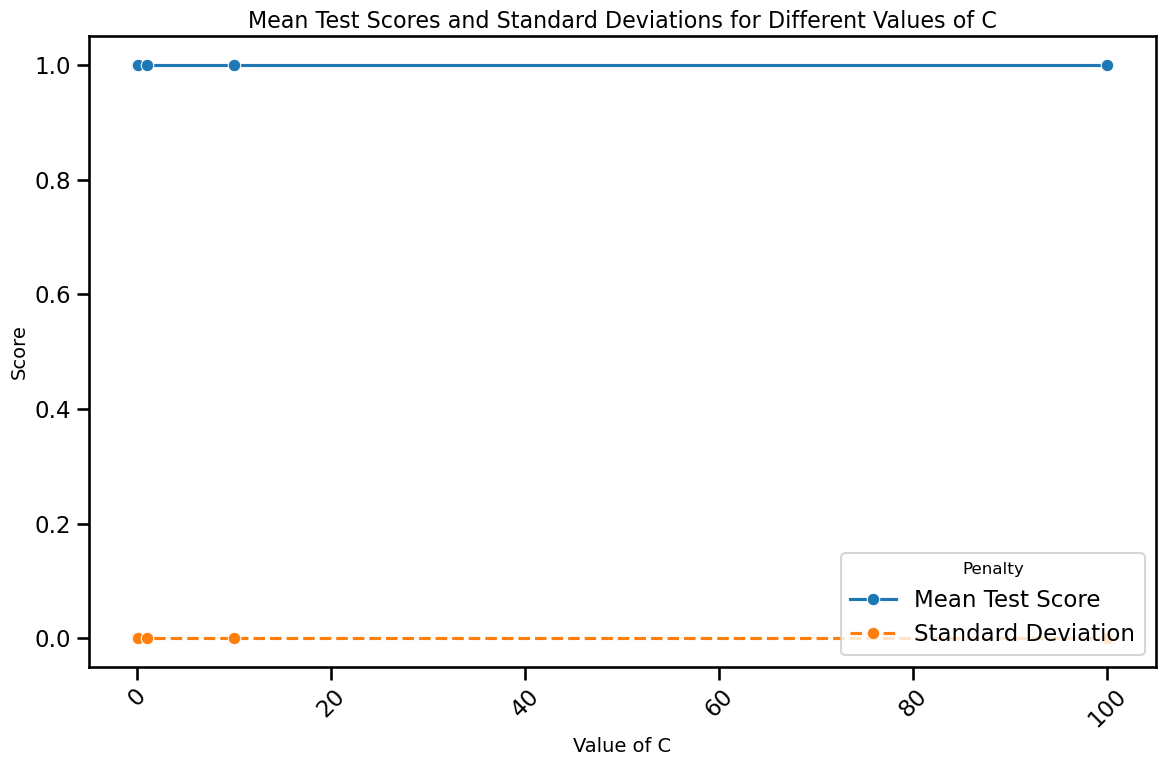

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract grid search results
grid_results_lr = pd.DataFrame(grid_search_lr.cv_results_)

# Set a larger font size
sns.set_context("talk")

# Plot the mean test scores and standard deviations for each penalty value
plt.figure(figsize=(12, 8))

# Plot mean test score for each penalty value
sns.lineplot(x=grid_results_lr[param_to_plot], y=grid_results_lr['mean_test_score'], marker='o', label='Mean Test Score')

# Plot standard deviation for each penalty value
sns.lineplot(x=grid_results_lr[param_to_plot], y=grid_results_lr['std_test_score'], marker='o', linestyle='dashed', label='Standard Deviation')

plt.xlabel('Value of C', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Mean Test Scores and Standard Deviations for Different Values of C', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Penalty', title_fontsize='12', loc='lower right')
plt.tight_layout()
plt.show()


## SVC

In [94]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

# Define the classifier and the pipeline for Support Vector Machine
classifier_svm = SVC(class_weight='balanced', probability=True, random_state=42)

pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', classifier_svm)])

# Define the hyperparameter grid for Support Vector Machine
param_grid_svm = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Create a 10-fold stratified cross-validation object
cv_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform grid search with cross-validation for Support Vector Machine
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=cv_svm, scoring='roc_auc', n_jobs=1)
grid_search_svm.fit(X, y)

# Display the best hyperparameters and corresponding score for Support Vector Machine
print("Best Hyperparameters:", grid_search_svm.best_params_)
print("Best ROC-AUC Score:", grid_search_svm.best_score_)

# Save the best Support Vector Machine model
best_model_svm = grid_search_svm.best_estimator_

# Evaluate the model using 10-fold cross-validation
cv_scores_svm = cross_val_score(best_model_svm, X, y, cv=cv_svm, scoring='roc_auc', n_jobs=-1)

# Display the cross-validated ROC-AUC scores for Support Vector Machine
print("Cross-validated ROC-AUC Scores:", cv_scores_svm)
print("Mean ROC-AUC Score:", cv_scores_svm.mean())

# Fit the pipeline on the training data
best_model_svm.fit(X, y)

# Make predictions on the test set
y_pred_svm = best_model_svm.predict(X_test)

# Evaluate the Support Vector Machine model performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
auc_roc_svm = roc_auc_score(y_test, best_model_svm.predict_proba(X_test)[:, 1])

# Save the validation and test scores for Support Vector Machine to a list
model_scores_svm = {
    'Best_Model_SVM': best_model_svm,
    'Validation_ROC_AUC_SVM': cv_scores_svm.mean(),
    'Test_Accuracy_SVM': accuracy_svm,
    'Test_Precision_SVM': precision_svm,
    'Test_Recall_SVM': recall_svm,
    'Test_F1_SVM': f1_svm,
    'Test_ROC_AUC_SVM': auc_roc_svm
}

# Print and access the saved scores for Support Vector Machine
for key, value in model_scores_svm.items():
    print(f'{key}: {value}')

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best ROC-AUC Score: 1.0
Cross-validated ROC-AUC Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean ROC-AUC Score: 1.0
Best_Model_SVM: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'INCOME', 'CODE',
                                                   'REASONCODE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   

***Plot mean and standard deviations (SVC)***

/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

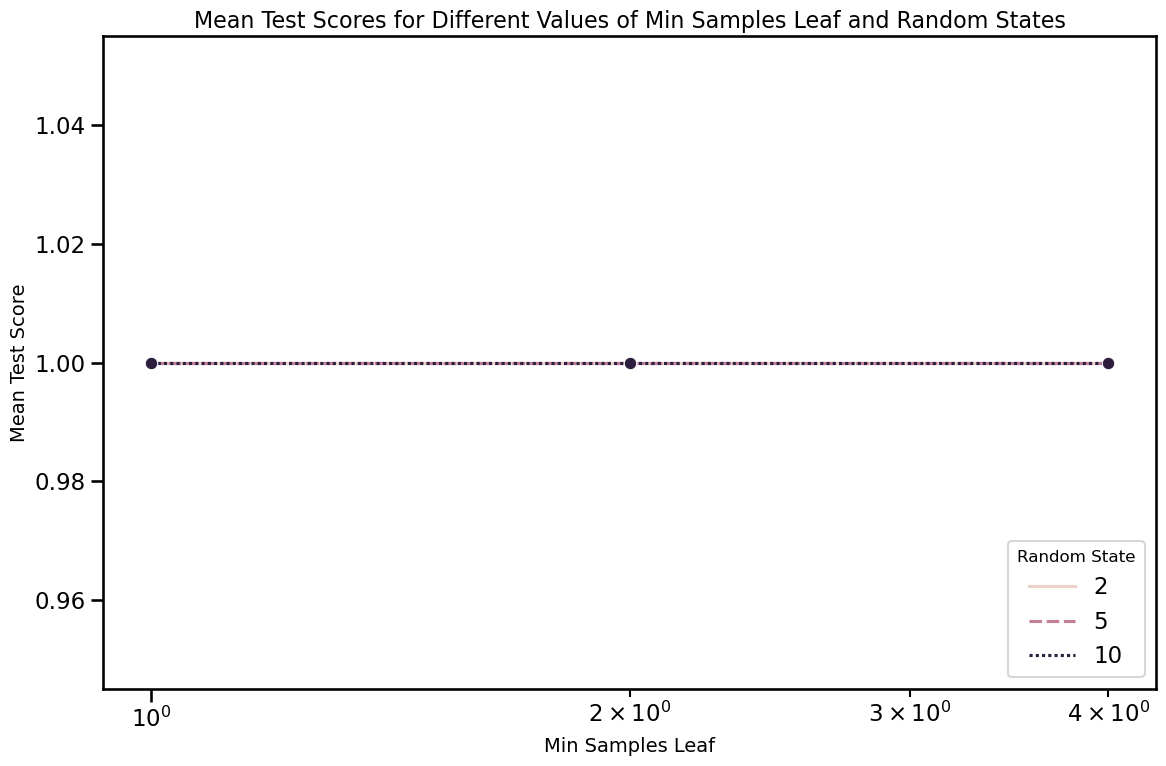

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract grid search results
grid_results = pd.DataFrame(grid_search.cv_results_)

# Set a larger font size
sns.set_context("talk")

# Define the hyperparameter to plot
param_to_plot = 'param_classifier__min_samples_leaf'

grid_results['random_state'] = grid_results['params'].apply(lambda x: x['classifier__min_samples_split'])

# Plot the mean test scores for each random state
plt.figure(figsize=(12, 8))

# Plot mean test score for each random state
sns.lineplot(x=grid_results[param_to_plot], y=grid_results['mean_test_score'], hue=grid_results['random_state'], style=grid_results['random_state'], marker='o')

plt.xscale('log')  # Assuming 'min_samples_leaf' is a parameter that can take values on a logarithmic scale
plt.xlabel('Min Samples Leaf', fontsize=14)
plt.ylabel('Mean Test Score', fontsize=14)
plt.title('Mean Test Scores for Different Values of Min Samples Leaf and Random States', fontsize=16)
plt.legend(title='Random State', title_fontsize='12', loc='lower right')
plt.tight_layout()
plt.show()

In [100]:
# Print the first parameter dictionary to inspect its structure
#print(grid_results['params'].iloc[0])
#print(grid_results.columns)


In [99]:
# Define the feature names for each transformer
#numeric_feature_names = preprocessor.named_transformers_['num'][-1].get_feature_names_out(num_ftrs)
#categorical_feature_names = preprocessor.named_transformers_['cat'][-1].get_feature_names_out(cat_ftrs)
#ordinal_feature_names = preprocessor.named_transformers_['ord'][-1].get_feature_names_out(ordinal_ftrs)

# Combine all feature names into a single list
#feature_names = list(numeric_feature_names) + list(categorical_feature_names) + list(ordinal_feature_names)

#print(feature_names)

## XGBoost

In [112]:
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score, recall_score

# Define the classifier and the pipeline
classifier = xgboost.XGBClassifier(random_state=42, scale_pos_weight=len(y[y==0])/len(y[y==1]))

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', classifier)])

# Define the parameter grid to search
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200],
}

# Define the scoring metrics (F1 score, AUC-ROC score, precision, and recall)
scorers = {
    'f1_score': make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorers, refit='roc_auc_score', n_jobs=-1)
grid_search.fit(X, y)

# Display the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

# Access the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC Score: {auc_roc:.4f}')


Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best ROC-AUC Score: 1.0
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC Score: 1.0000


***Plot means and standard deviations (XGBoost)***

/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before

<Figure size 1200x800 with 0 Axes>

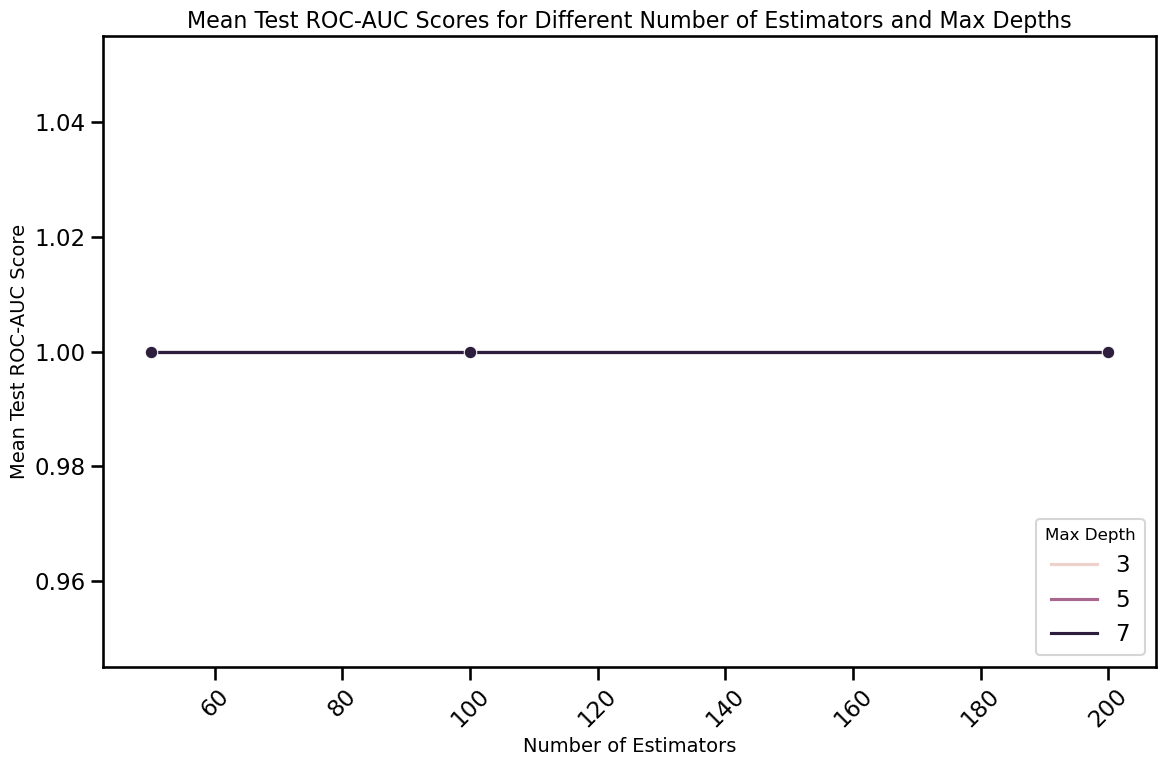

/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before

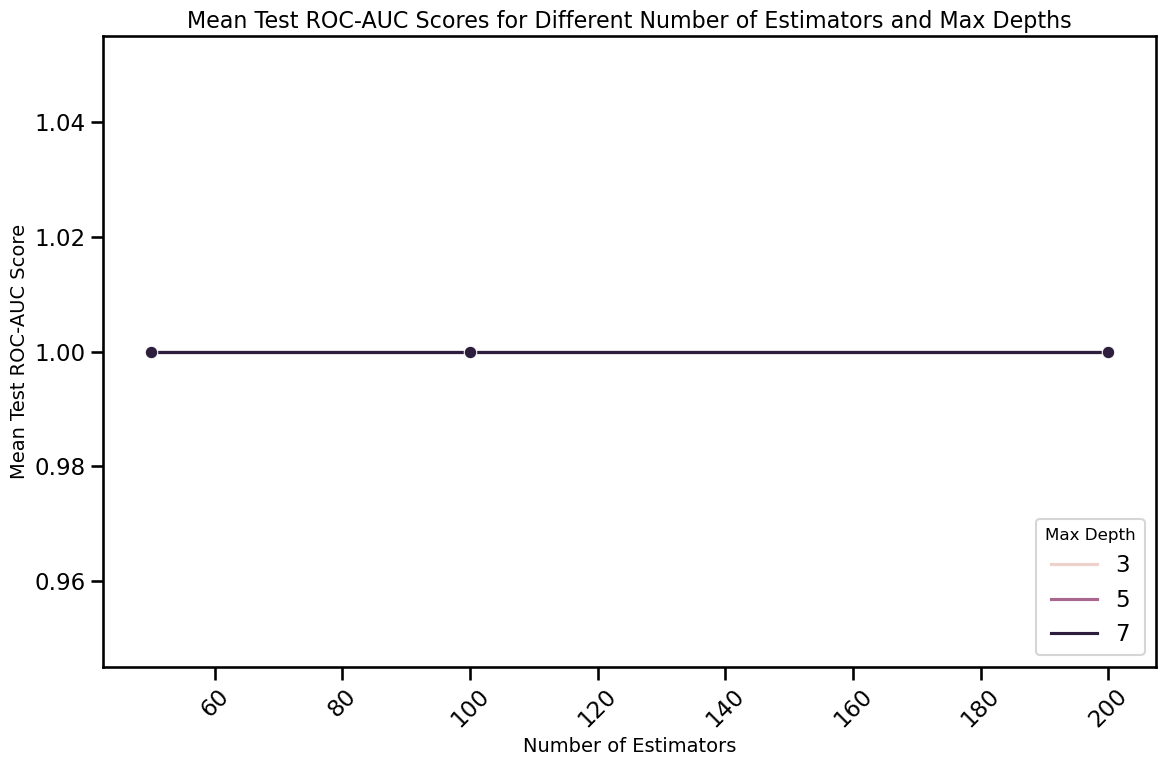

/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before

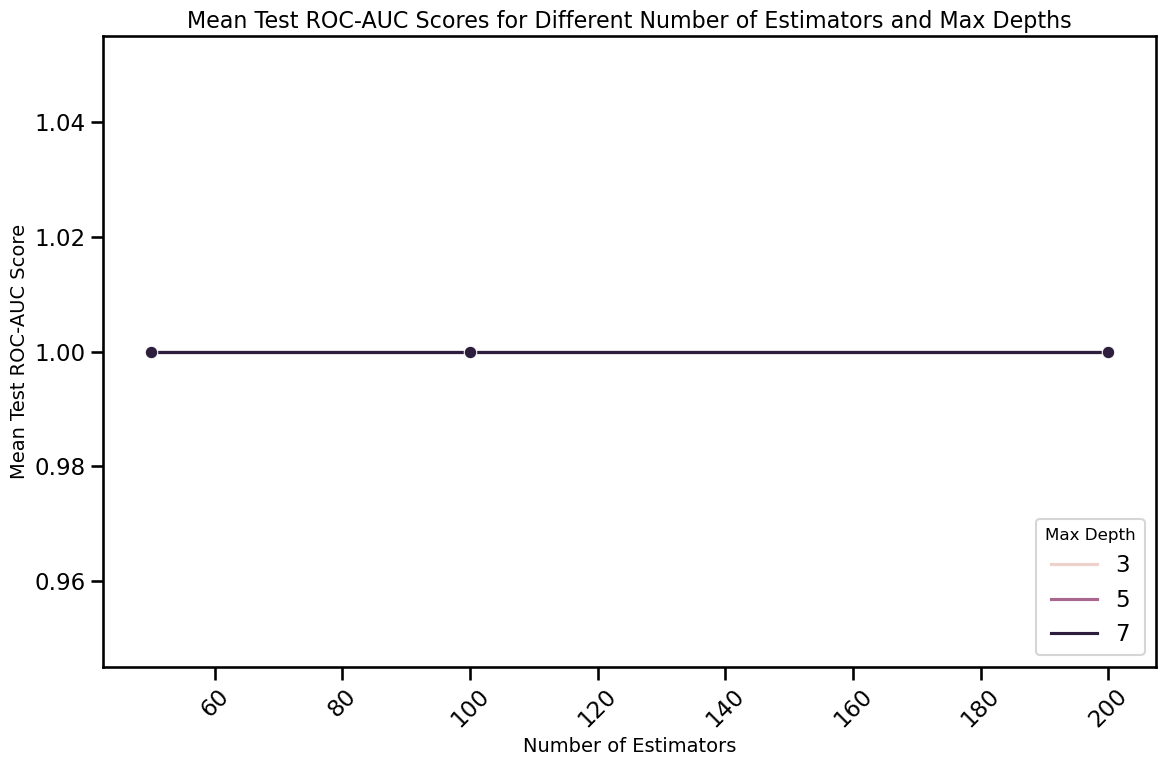

/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before

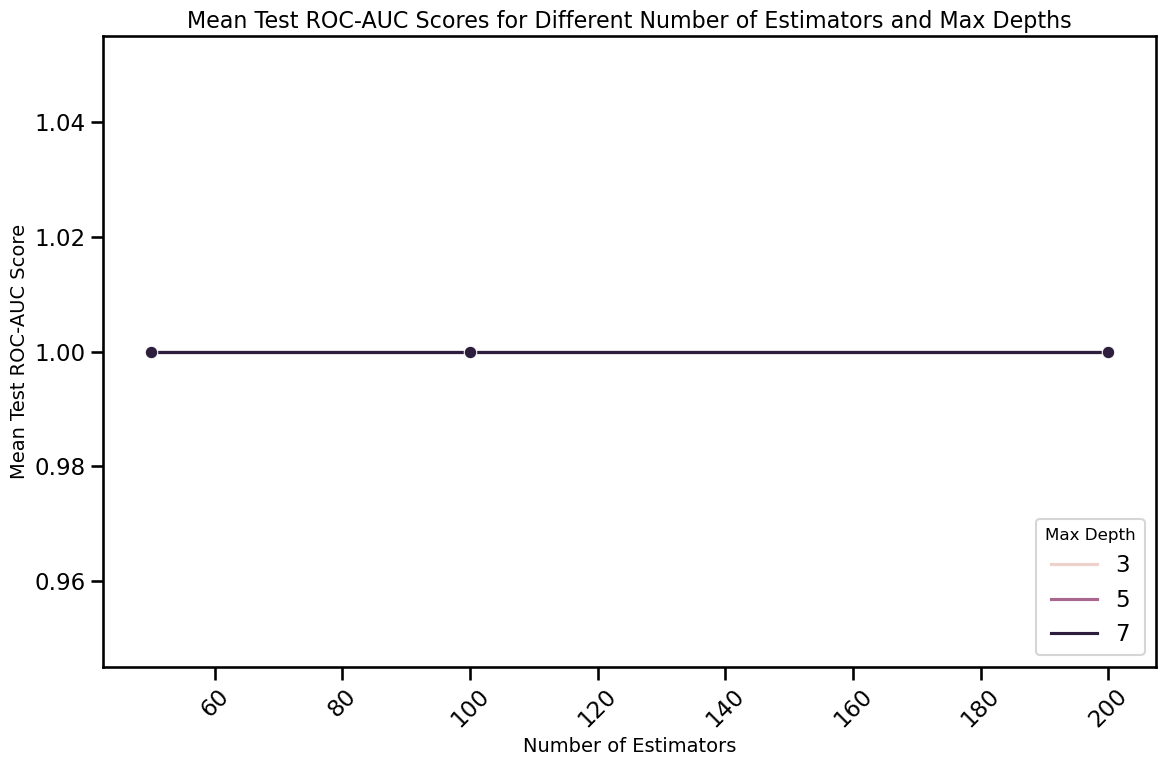

/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/SarahA/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before

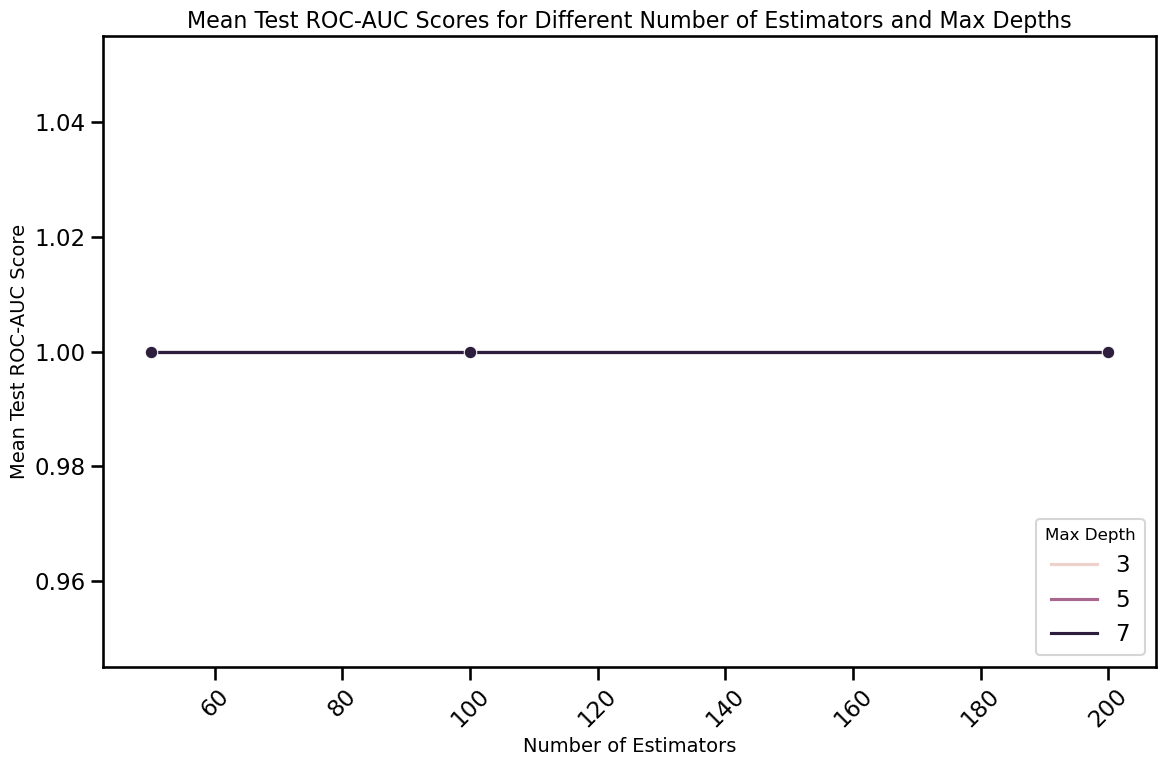

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract grid search results
grid_results = pd.DataFrame(grid_search.cv_results_)

# Set a larger font size
sns.set_context("talk")

# Define the hyperparameter to plot
param_to_plot = 'param_classifier__n_estimators'

# Extract random states from 'params' column
grid_results['random_state'] = grid_results['params'].apply(lambda x: x['classifier__max_depth'])

# Plot the mean test scores and standard deviations for each random state
plt.figure(figsize=(12, 8))

# Loop over each fold
for fold in range(grid_search.cv):
    fold_data = grid_results[grid_results['split{}_test_roc_auc_score'.format(fold)].notnull()]

    # Plot mean test score for each random state and fold
    plt.figure(figsize=(12, 8))
    sns.lineplot(x=grid_results[param_to_plot], y=fold_data['mean_test_roc_auc_score'], hue=fold_data['random_state'], marker='o')

    plt.xlabel('Number of Estimators', fontsize=14)
    plt.ylabel('Mean Test ROC-AUC Score', fontsize=14)
    plt.title('Mean Test ROC-AUC Scores for Different Number of Estimators and Max Depths', fontsize=16)
    plt.xticks(rotation=45)
    plt.legend(title='Max Depth', title_fontsize='12', loc='lower right')
    plt.tight_layout()
    plt.show()


In [101]:
#print(grid_search.cv_results_.keys())


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


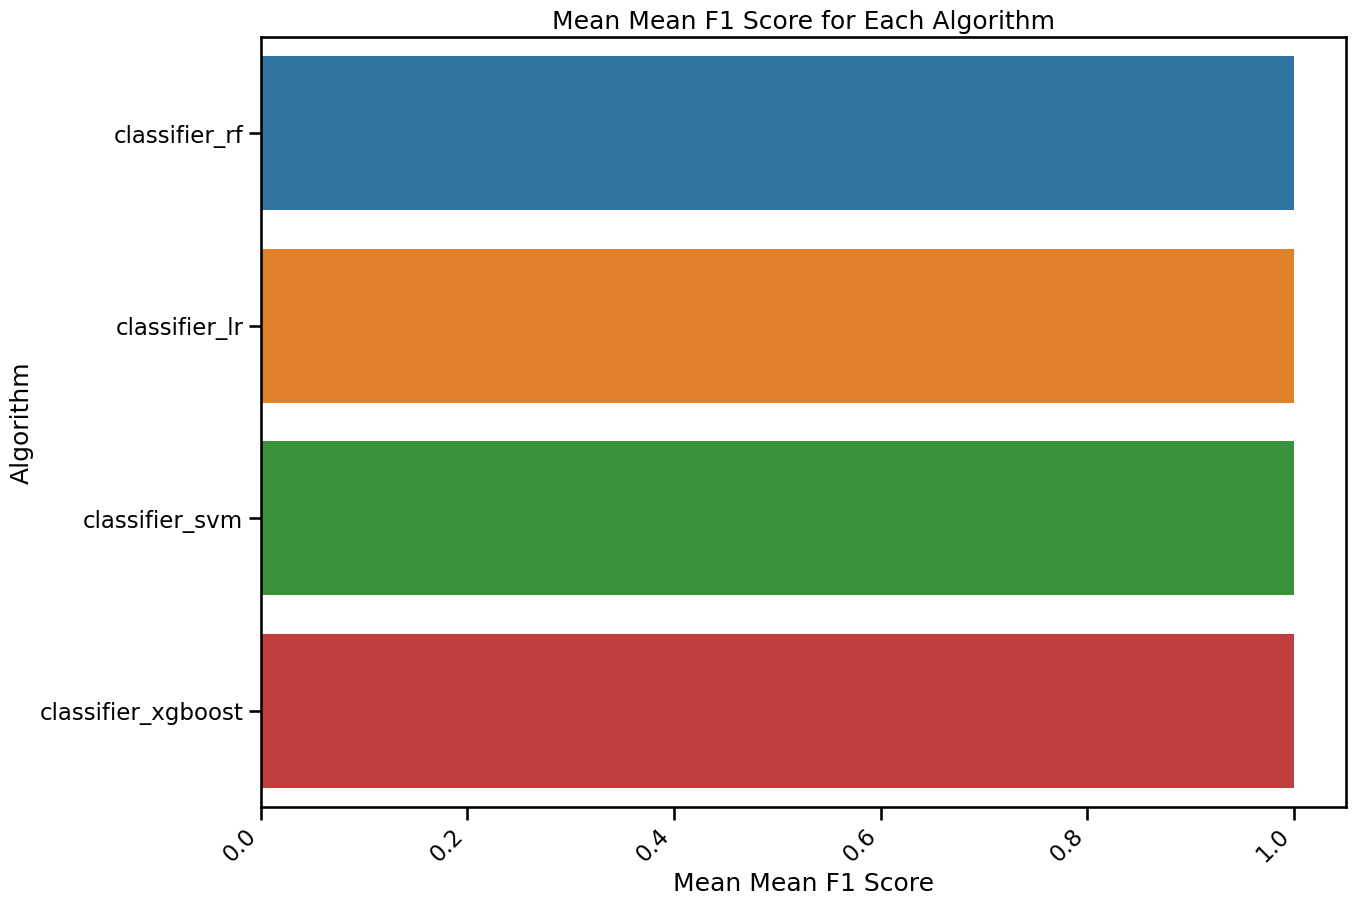

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


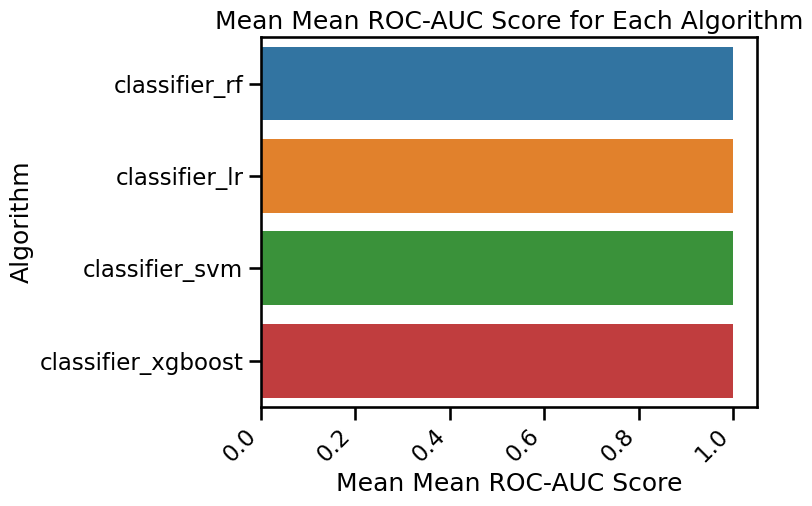

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


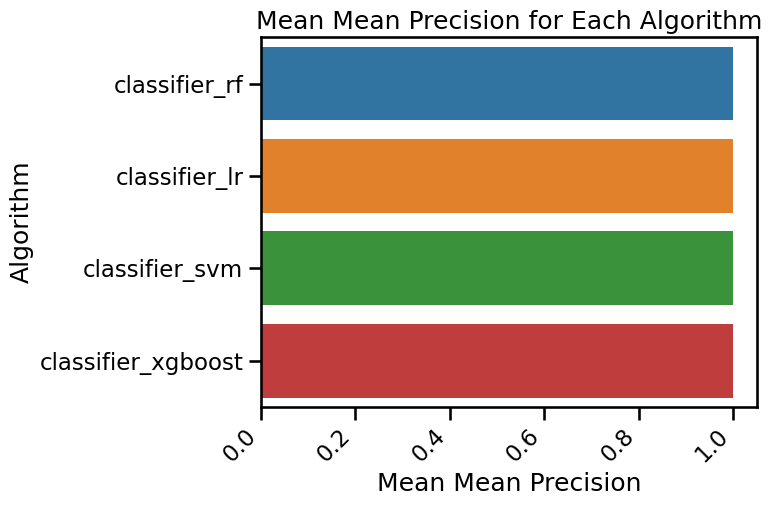

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


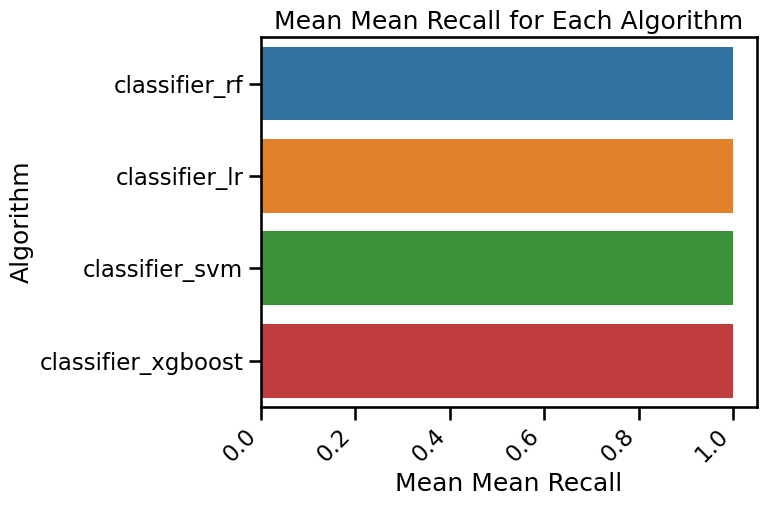

Mean Scores:
            Algorithm  Mean F1 Score  Mean ROC-AUC Score  Mean Precision  \
0       classifier_rf            1.0                 1.0             1.0   
1       classifier_lr            1.0                 1.0             1.0   
2      classifier_svm            1.0                 1.0             1.0   
3  classifier_xgboost            1.0                 1.0             1.0   

   Mean Recall  
0          1.0  
1          1.0  
2          1.0  
3          1.0  


In [144]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score, recall_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

classifiers = {
    'classifier_rf': RandomForestClassifier(),
    'classifier_lr': LogisticRegression(),
    'classifier_svm': SVC(),
    'classifier': XGBClassifier()
}


# Initialize an empty list to store mean scores for each algorithm
mean_scores_list = []

# Define the scoring metrics (F1 score, AUC-ROC score, precision, and recall)
scorers = {
    'f1_score': make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

for name, classifier in classifiers.items():
    # Create a pipeline with the current classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', classifier)])
    
    # Perform cross-validation and calculate mean scores
    mean_f1 = cross_val_score(pipeline, X, y, cv=5, scoring=scorers['f1_score']).mean()
    mean_roc_auc = cross_val_score(pipeline, X, y, cv=5, scoring=scorers['roc_auc_score']).mean()
    mean_precision = cross_val_score(pipeline, X, y, cv=5, scoring=scorers['precision']).mean()
    mean_recall = cross_val_score(pipeline, X, y, cv=5, scoring=scorers['recall']).mean()
    
    # Append the mean scores to the list of dictionaries
    mean_scores_list.append({
        'Algorithm': name,
        'Mean F1 Score': mean_f1,
        'Mean ROC-AUC Score': mean_roc_auc,
        'Mean Precision': mean_precision,
        'Mean Recall': mean_recall
    })

# Create a DataFrame from the list of dictionaries
mean_scores = pd.DataFrame(mean_scores_list)

# Set a larger font size
sns.set_context("talk")

mean_scores['Algorithm'] = mean_scores['Algorithm'].replace({'classifier': 'classifier_xgboost'})

# Plot mean values for each algorithm
plt.figure(figsize=(14, 10))

# Specify the columns to plot
columns_to_plot = ['Mean F1 Score', 'Mean ROC-AUC Score', 'Mean Precision', 'Mean Recall']

# Loop over each column and plot
for column in columns_to_plot:
    sns.barplot(x=column, y='Algorithm', data=mean_scores, orient='h')
    plt.title(f'Mean {column} for Each Algorithm')
    plt.xlabel(f'Mean {column}')
    plt.ylabel('Algorithm')
    plt.xticks(rotation=45, ha='right')  # Increase rotation angle
    plt.show()

# Display the DataFrame of mean scores
print("Mean Scores:")
print(mean_scores)
